In [1]:
import netCDF4
import numpy as np
from numpy.fft import fft, ifft
from numpy import genfromtxt
import matplotlib.pyplot as plt
import matplotlib.dates as mpldts
from scipy.stats import binned_statistic
import datetime# as dt
import urllib
import time
import calendar
import csv

In [2]:
stn = '154' #067
dataset = 'archive' # Enter 'archive' or 'realtime'
deploy = '12' # If archive dataset, set deployment number from .nc file

start_date = '06/20/2023 9:00' # MM/DD/YYYY HH:MM
duration  = 30 # Set length of timeseries (minutes)

qc_level = 2 # Filter data with qc flags above this number

# Archive
data_url = 'http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/archive/' + stn + 'p1/' + stn + 'p1_d' + deploy + '.nc'
# Realtime
if dataset == 'realtime':
    data_url = 'http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/realtime/' + stn + 'p1_xy.nc'


nc = netCDF4.Dataset(data_url)
# Turn off auto masking
nc.set_auto_mask(False)
#nc
data_url

'http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/archive/154p1/154p1_d12.nc'

In [3]:
xdisp = nc.variables['xyzXDisplacement'] # Make a numpy array of three directional displacement variables (x, y, z)
ydisp = nc.variables['xyzYDisplacement']
zdisp = nc.variables['xyzZDisplacement']
qc_flag = nc.variables['xyzFlagPrimary']
filter_delay = nc.variables['xyzFilterDelay']
start_time = nc.variables['xyzStartTime'][:] # Variable that gives start time for buoy data collection
sample_rate = nc.variables['xyzSampleRate'][:] # Variable that gives rate (frequency, Hz) of sampling
end_time = start_time + (len(xdisp)/sample_rate) # Calulate end time for buoy data collection


Fq_cdip = np.asarray(nc.variables['waveFrequency'])
Ed_cdip = np.asarray(nc.variables['waveEnergyDensity'])
waveTime = nc.variables['waveTime'][:]
Dmean_cdip = nc.variables['waveMeanDirection']

# Find nearest value in numpy array
def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return array[idx]

# Convert to unix timestamp
def get_unix_timestamp(human_time,dateFormat):
    unix_timestamp = int(calendar.timegm(datetime.datetime.strptime(human_time, dateFormat).timetuple()))
    return unix_timestamp

# Convert to human readable timestamp
def get_human_timestamp(unix_timestamp, dateFormat):
    human_timestamp = datetime.datetime.utcfromtimestamp(int(unix_timestamp)).strftime(dateFormat)
    return human_timestamp

    
# Check start and end dates of deployment
data_start = get_human_timestamp(start_time - filter_delay[0],"%m/%d/%Y %H:%M:%S")
data_end = get_human_timestamp(end_time - filter_delay[0],"%m/%d/%Y %H:%M:%S")
print("data_start: " + data_start)
print("  data_end: " + data_end)

# Find UNIX timestamps for user human-formatted start/end dates
unix_start = get_unix_timestamp(start_date,"%m/%d/%Y %H:%M") 
unix_end = unix_start + (duration * 60) # Create UNIX end stamp by adding duration to 'unix_start'

nearest_start = find_nearest(waveTime, unix_start)  # Find the closest unix timestamp
nearest_index = np.where(waveTime==nearest_start)[0][0]  # Grab the index number of found date

# Create specialized array using UNIX Start and End times minus Filter Delay, and Sampling Period (1/sample_rate) 
# to calculate sub-second time values that correspond to Z-Displacement sampling values
sample_time = np.arange((start_time - filter_delay[0]), end_time - filter_delay[0],(1/(sample_rate)))

# Find corresponding start/end date index numbers in 'sample_time' array    
start_index = sample_time.searchsorted(unix_start) 
end_index = sample_time.searchsorted(unix_end)


sample_time_cut = sample_time[start_index:end_index]
sample_time_cut *= 1000
t = sample_time_cut.astype('datetime64[ms]').astype(datetime.datetime)

data_start: 11/03/2022 14:57:46
  data_end: 10/28/2024 16:57:46


In [4]:
# Limit data to date/times
x = xdisp[start_index:end_index]
y = ydisp[start_index:end_index]
z = zdisp[start_index:end_index]
qc = qc_flag[start_index:end_index]

# Filter out by quality control level
x = np.ma.masked_where(qc>qc_level,x)
y = np.ma.masked_where(qc>qc_level,y)
z = np.ma.masked_where(qc>qc_level,z)

#dt = np.mean(np.diff(t))
dt = 0.78125

NameError: name 'station_title' is not defined

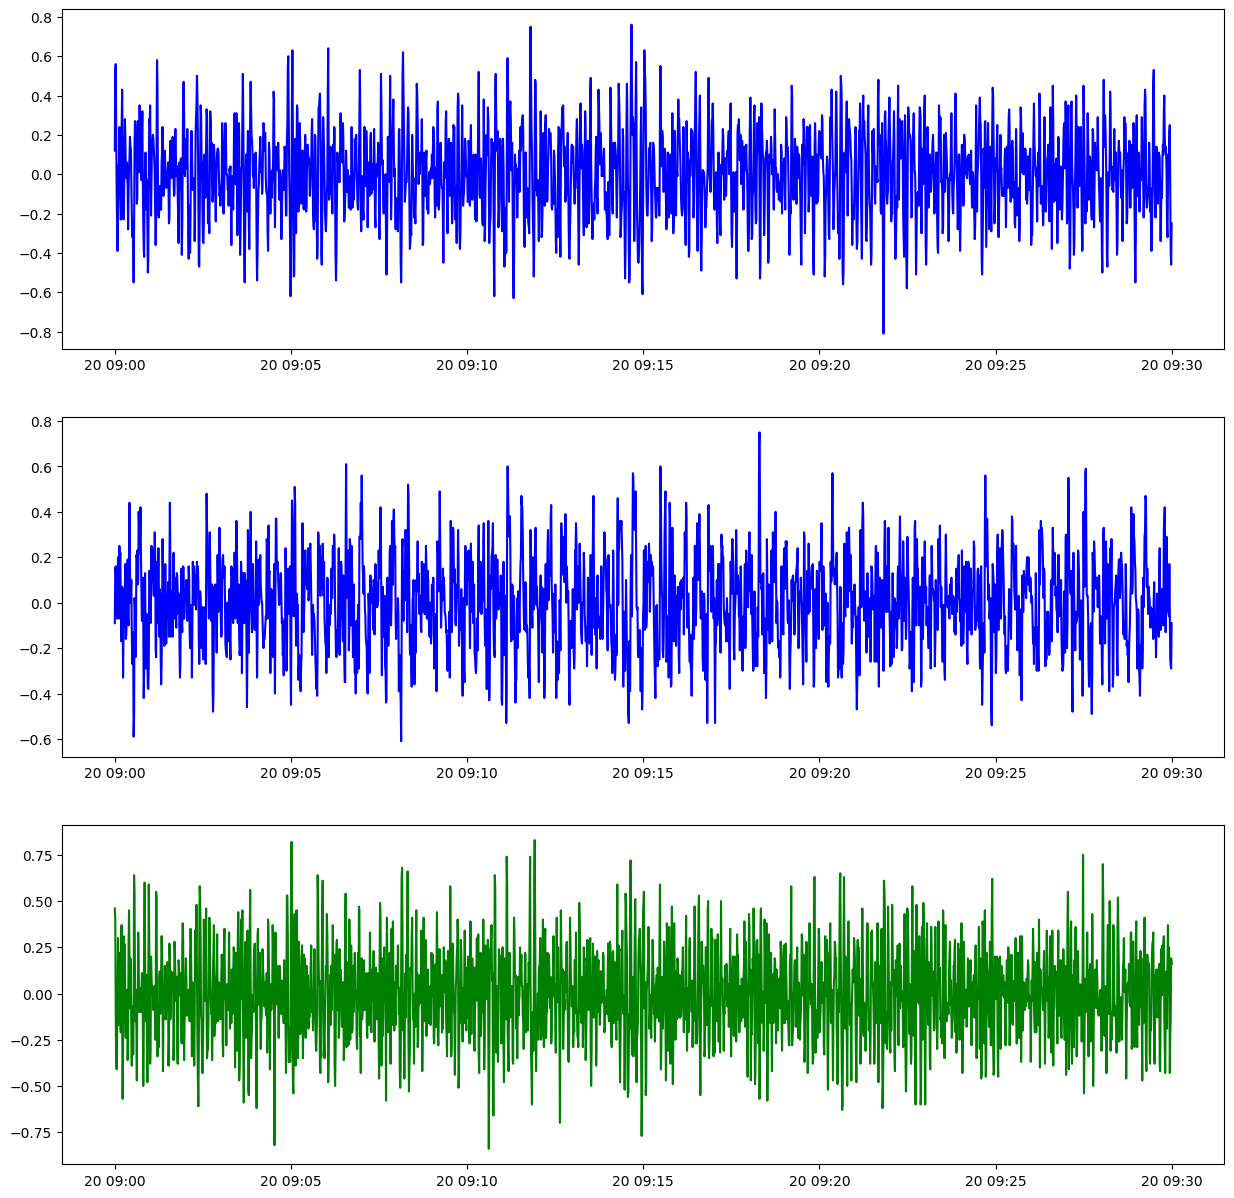

In [5]:
# Specify figure size
fig = plt.figure(figsize=(15,15))

# Create 3 stacked subplots for three Directional Displacement Parameters (xyz)
plt_x = plt.subplot(3,1,1)
plt_x.plot(t,x,'b')
plt_y = plt.subplot(3,1,2, sharex=plt_x)
plt_y.plot(t,y,'b')
plt_z = plt.subplot(3,1,3, sharex=plt_x)
plt_z.plot(t,z,'g')

# Set titles
plt.suptitle(station_title + "\n" + "Time: " + start_date, fontsize=22, y=0.97)

# Set x-axis tick format to "HH:MM:SS" and tick interval to every 5 minutes
#days = mpldts.MinuteLocator(interval=5) 
daysFmt = mpldts.DateFormatter('%H:%M:%S')
#plt.gca().xaxis.set_major_locator(days)
plt.gca().xaxis.set_major_formatter(daysFmt)

ymin=np.floor(min(min(x), min(y), min(z)))
ymax=np.ceil(max(max(x), max(y), max(z)))

# Set y-axis limits for each plot
plt_x.set_ylim(ymin,ymax)
plt_y.set_ylim(ymin,ymax)
plt_z.set_ylim(ymin,ymax)

# Label each subplot title
plt_x.set_title('North/South Displacement', fontsize=14)
plt_y.set_title('East/West Displacement', fontsize=14)
plt_z.set_title('Vertical Displacement', fontsize=14,y=1)

# Label each y-axis
plt_x.set_ylabel('X Displacement (m)', fontsize=14)
plt_y.set_ylabel('Y Displacement (m)', fontsize=14)
plt_z.set_ylabel('Z Displacement (m)', fontsize=14)

# Label x-axis
plt.xlabel('Time (UTC)', fontsize=18)

# Plot dashed gridlines
plt_x.grid(axis='y', which='major', color='b', linestyle='-', alpha=0.25)
plt_y.grid(axis='y', which='major', color='b', linestyle='-', alpha=0.25)
plt_z.grid(axis='y', which='major', color='g', linestyle='-', alpha=0.25)

In [ ]:
def compute_1d_spectrum(eta,dx):
    etak = fft(eta)
    Nfft = len(eta)
    k = np.fft.fftfreq(Nfft)/(dx)
    # compute spectrum
    PSD=np.abs(etak)**2/Nfft**2/dk # power spectral density ( m^2 / cpm )
    # keep only positive frequencies
    Npos=int(Nfft/2)
    kp = k[0:Npos]
    PSD=2*PSD[0:Npos] # times two to account for the variance of the ambigous negative frequencies
    return PSD,kp  # smoothed spectrum PSDs at center wavenumber ksc

def spectrum_smooth(PSD,w,Nave):
    # Smooth the spectum by a fcator Nave (compute a bin average by a factor Nave)
    # w is the wavenumber or frquency array
    # PSD is the power spectrum
    PSDs=binned_statistic(w,PSD,bins=len(PSD)/Nave).statistic
    ws=binned_statistic(w,PSD,bins=len(PSD)/Nave).bin_edges
    wsc=(ws[0:-1:]+ws[1::])/2 # center bin
    return PSDs,wsc  # smoothed spectrum PSDs at center wavenumber wsc

def filt1d(data, window):
    """
    Smooths a 1D spectrum using a moving average filter.
    
    Parameters:
    data (array-like): The 1D spectral data to be smoothed.
    window_size (int): The size of the moving average window.
    
    Returns:
    numpy.ndarray: The smoothed 1D spectrum, with length reduced by (window_size - 1).
    
    Author: UCONN AirSea Lab, 2022
    """

    return np.convolve(data, window, mode='same')

def compute_auto_spectrum(data1,dx):
    etak = fft(data1)
    Nfft = len(data1)
    k = np.fft.fftfreq(Nfft)/(dx)
    # compute spectrum
    PSD= (etak * np.conj(etak))/Nfft**2/dk # power spectral density ( m^2 / cpm )
    # keep only positive frequencies
    Npos=int(Nfft/2)
    kp = k[0:Npos]
    PSD=2*PSD[0:Npos] # times two to account for the variance of the ambigous negative frequencies
    return PSD,kp  # smoothed spectrum PSDs at center wavenumber ksc

def compute_cross_spectrum(data1,data2,dx):
    data1k = fft(data1)
    data2k = fft(data2)
    Nfft = len(data1)
    k = np.fft.fftfreq(Nfft)/(dx)
    # compute spectrum
    PSD= (data1k * np.conj(data2k))/Nfft**2/dk # power spectral density ( m^2 / cpm )
    # keep only positive frequencies
    Npos=int(Nfft/2)
    kp = k[0:Npos]
    PSD=2*PSD[0:Npos] # times two to account for the variance of the ambigous negative frequencies

    return PSD,kp  # smoothed spectrum PSDs at center wavenumber ksc

In [6]:
# def taper_spec(data):
#     #data = x
#     Nfft = len(data)
    
#     # Hann taper
#     taper=.5*(1 - np.cos(2*np.pi*(np.arange(0,Nfft)/(Nfft-1))))
    
#     # apply taper 
#     data_taper= data*taper
#     np.where(data_taper < -4)
#     ind =np.where(data_taper < -4)
#     data_taper[ind] = 0.#None
#     Fac=np.var(data)/np.var(data_taper)
    
#     dk = 1/len(data)
#     #print(dk)
    
#     [PSD,w]=compute_auto_spectrum(data_taper,dk)
#     dw=np.mean(np.diff(w));
#     PSD=PSD*Fac # correct variance lost due to taper
    
#     Nave=10
#     # smooth the spectra by coarsening the spectrum by a factor of 10 and averaging the data in each bin.
#     [PSD,wsc]=spectrum_smooth(PSD,w,Nave)
#     DOFs=2*Nave #degress of freedom
    
    
#     # add addional smoothing with a running filter
    
#     wfilt=np.ones(5);#/window_size;
#     DOFf=sum(wfilt);
#     # normalize filter
#     wfilt=wfilt/sum(wfilt)
    
#     PSD=filt1d(PSD, wfilt);
    
#     DOFs2=DOFs*DOFf
    
#     return PSD

In [7]:
Nfft = len(x)
dt = 0.78125
dk = 1/len(t)

# Hann taper
taper=.5*(1 - np.cos(2*np.pi*(np.arange(0,Nfft)/(Nfft-1))))

####################### apply taper x ###########################
x_taper= x*taper
np.where(x_taper < -4)
ind =np.where(x_taper < -4)
x_taper[ind] = 0.#None
Fac_x=np.var(x)/np.var(x_taper)


[PSDt_x,w]=compute_1d_spectrum(x_taper,dt)
dw=np.mean(np.diff(w));
PSDt_x=PSDt_x*Fac_x # correct variance lost due to taper

Nave=10
# smooth the spectra by coarsening the spectrum by a factor of 10 and averaging the data in each bin.
[PSDts_x,wsc]=spectrum_smooth(PSDt_x,w,Nave)
DOFs=2*Nave #degress of freedom


# add addional smoothing with a running filter

wfilt=np.ones(5);#/window_size;
DOFf=sum(wfilt);
# normalize filter
wfilt=wfilt/sum(wfilt)

PSD_x=filt1d(PSDts_x, wfilt);

DOFs2=DOFs*DOFf

################################# apply taper y ###############################
y_taper= y*taper
np.where(y_taper < -4)
ind =np.where(y_taper < -4)
y_taper[ind] = 0.#None
Fac_y=np.var(y)/np.var(y_taper)


[PSDt_y,w]=compute_1d_spectrum(y_taper,dt)
dw=np.mean(np.diff(w));
PSDt_y=PSDt_y*Fac_y # correct variance lost due to taper

Nave=10
# smooth the spectra by coarsening the spectrum by a factor of 10 and averaging the data in each bin.
[PSDts_y,wsc]=spectrum_smooth(PSDt_y,w,Nave)
DOFs=2*Nave #degress of freedom


# add addional smoothing with a running filter

wfilt=np.ones(5);#/window_size;
DOFf=sum(wfilt);
# normalize filter
wfilt=wfilt/sum(wfilt)

PSD_y=filt1d(PSDts_y, wfilt);

DOFs2=DOFs*DOFf
DOFs2

####################### apply taper z #########################
z_taper= z*taper
np.where(z_taper < -4)
ind =np.where(z_taper < -4)
z_taper[ind] = 0.#None
Fac_z=np.var(z)/np.var(z_taper)

[PSDt_z0,w]=compute_1d_spectrum(z_taper,dt)
dw=np.mean(np.diff(w));
PSDt_z=PSDt_z0*Fac_z # correct variance lost due to taper

Nave=10
# smooth the spectra by coarsening the spectrum by a factor of 10 and averaging the data in each bin.
[PSDts_z,wsc]=spectrum_smooth(PSDt_z,w,Nave)
DOFs=2*Nave #degress of freedom


# add addional smoothing with a running filter

wfilt=np.ones(5);#/window_size;
DOFf=sum(wfilt);
# normalize filter
wfilt=wfilt/sum(wfilt)

PSD_z=filt1d(PSDts_z, wfilt);

DOFs2=DOFs*DOFf
DOFs2

NameError: name 'compute_1d_spectrum' is not defined

In [ ]:
# PSD_x = taper_spec(x)
# PSD_y = taper_spec(y)
# PSD_z = taper_spec(z)

np.shape(PSD_x), np.shape(PSD_y), np.shape(PSD_z), np.shape(wsc)

In [ ]:
def fourier_calculations(x,y,z,dt):
    Nave = 10
    
    #finding Qyz
    [PSD_yz,kp] = compute_cross_spectrum(y,z,dt)
    [PSD_yz,wsc]=spectrum_smooth(PSD_yz,w,Nave)
    DOFs=2*Nave #degress of freedom
    
    # add addional smoothing with a running filter
    
    wfilt=np.ones(5);#/window_size;
    DOFf=sum(wfilt);
    # normalize filter
    wfilt=wfilt/sum(wfilt)
    
    PSD_yz=filt1d(PSD_yz, wfilt);
    Qyz = np.imag(PSD_yz)
    
    
    #finding Qxz
    [PSD_xz,kp] = compute_cross_spectrum(x,z,dt)
    np.shape(PSD_xz)
    
    [PSD_xz,wsc]=spectrum_smooth(PSD_xz,w,Nave)
    DOFs=2*Nave #degress of freedom

    # add addional smoothing with a running filter
    
    wfilt=np.ones(5);#/window_size;
    DOFf=sum(wfilt);
    # normalize filter
    wfilt=wfilt/sum(wfilt)
    
    PSD_xz=filt1d(PSD_xz, wfilt);
    Qxz = np.imag(PSD_xz)
    
    
    #finding Cxy
    [PSD_xy,kp] = compute_cross_spectrum(x,y,dt)
    [PSD_xy,wsc]=spectrum_smooth(PSD_xy,w,Nave)
    DOFs=2*Nave #degress of freedom
    
    # add addional smoothing with a running filter
    
    wfilt=np.ones(5);#/window_size;
    DOFf=sum(wfilt);
    # normalize filter
    wfilt=wfilt/sum(wfilt)
    
    PSD_xy=filt1d(PSD_xy, wfilt);
    Cxy = np.real(PSD_xy)
    
    
    #calculating fourier coefficients
    a1 = Qxz/((PSD_z*(PSD_x+PSD_y))**(1/2))
    b1 = Qyz/((PSD_z*(PSD_x+PSD_y))**(1/2))
    b2 = (2*Cxy)/(PSD_x+PSD_y)
    a2 = (PSD_x - PSD_y)/(PSD_x+PSD_y)

    return a1,b1,a2,b2

In [ ]:
PSD_y

In [ ]:
[a1,b1,a2,b2] = fourier_calculations(x,y,z,dt)

In [ ]:
a1

In [ ]:
plt.figure(figsize = (12, 6))
plt.plot(wsc, a1, 'b')
plt.plot(wsc, b1, 'r')
plt.plot(wsc, a2, 'k')
plt.plot(wsc, b2, 'g')
plt.ylabel('Coefficients')
plt.xlabel('k')
plt.legend(['a1','b1','a2','b2'])
plt.ylim(-2,5)

In [ ]:
theta_m = np.arctan(b1/a1)
theta = np.linspace(0,2*np.pi,115)

dtheta = np.abs(np.mean(np.diff(theta)))
dtheta

In [ ]:
D_f_theta = 1/(2*np.pi) + 1/(np.pi)*((a1[:,np.newaxis]*np.cos(1*theta) 
                                      + b1[:,np.newaxis]*np.sin(1*theta)) 
                                     + (a2[:,np.newaxis]*np.cos(2*theta) 
                                                + b2[:,np.newaxis]*np.sin(2*theta)))

np.shape(D_f_theta)

In [ ]:
PSD_z

In [ ]:
Pzz = PSD_z
Psi = np.multiply(Pzz,D_f_theta)
Psi

In [ ]:
dtheta = np.mean(np.diff(theta))
#dtheta = np.mean(np.diff(theta_values))
print(f' The integral of the dir distr is = {np.mean(np.nansum(D_f_theta, axis =1)*dtheta)}')

In [ ]:
#fig = plt.figure(figsize=(11,11))
fig = plt.figure(figsize=(6,6))

#radii = Fq[0:35] # Only call frequency bands > 0.3 Hz
#thetas = Dmean_rad[:]
thetas = theta[:]

## Color-scale
contour_levels = np.arange(-0.02,0.1,0.001) # Manually set colorbar min/max values
#contour_levels = np.arange(np.min(Psi),np.max(Psi),0.0001) # Manually set colorbar min/max values
#contour_levels = np.arange(np.min(Psi),np.max(Psi)/2,0.000001) # Manually set colorbar min/max values
#contour_levels = np.arange(Edfloat/1000,Edfloat/2,0.0001) # Automatically set colorbar min/max values based on 'Ed'

ax = plt.subplot(111, polar=True)
ax.set_theta_direction(-1)
ax.set_theta_zero_location("N")
ylabels = ([20,10,6.7,5,4])
ax.set_yticklabels(ylabels)

#colorax = ax.contourf(thetas, radii, Ednew[0:35],contour_levels)
#colorax = ax.contourf(thetas, wsc, Psi,contour_levels)
colorax = ax.contourf(theta, wsc, Psi,contour_levels, extend="both")


## Set titles and colorbar
#suptitle('Polar Spectrum at Stn. ' + stn, fontsize=22, y=0.95, x=0.45)
#title(startdate, fontsize=16, y=1.11)

cbar = fig.colorbar(colorax)
cbar.set_label('Energy Density (m*m/Hz/deg)', rotation=270, fontsize=16)
cbar.ax.get_yaxis().labelpad = 30

degrange = range(0,360,30)
#lines, labels = plt.thetagrids(degrange, labels=None, frac = 1.07)

In [ ]:
def plot_spec(PSD_z,wsc,a1,b1,a2,b2):
    theta = np.linspace(0,2*np.pi,115)
    
    D_f_theta = 1/(2*np.pi) + 1/(np.pi)*((a1[:,np.newaxis]*np.cos(1*theta) 
                                      + b1[:,np.newaxis]*np.sin(1*theta)) 
                                     + (a2[:,np.newaxis]*np.cos(2*theta) 
                                                + b2[:,np.newaxis]*np.sin(2*theta)))

    Psi = np.multiply(PSD_z,D_f_theta)


    fig = plt.figure(figsize=(6,6))
    
    #radii = Fq[0:35] # Only call frequency bands > 0.3 Hz
    #thetas = Dmean_rad[:]
    thetas = theta[:]
    
    ## Color-scale
    contour_levels = np.arange(-0.02,0.1,0.001) # Manually set colorbar min/max values
    #contour_levels = np.arange(np.min(Psi),np.max(Psi),0.0001) # Manually set colorbar min/max values
    #contour_levels = np.arange(np.min(Psi),np.max(Psi)/2,0.000001) # Manually set colorbar min/max values
    #contour_levels = np.arange(Edfloat/1000,Edfloat/2,0.0001) # Automatically set colorbar min/max values based on 'Ed'
    
    ax = plt.subplot(111, polar=True)
    ax.set_theta_direction(-1)
    ax.set_theta_zero_location("N")
    ylabels = ([20,10,6.7,5,4])
    ax.set_yticklabels(ylabels)
    
    #colorax = ax.contourf(thetas, radii, Ednew[0:35],contour_levels)
    #colorax = ax.contourf(thetas, wsc, Psi,contour_levels)
    colorax = ax.contourf(theta, wsc, Psi,contour_levels, extend="both")
    
    
    ## Set titles and colorbar
    #suptitle('Polar Spectrum at Stn. ' + stn, fontsize=22, y=0.95, x=0.45)
    #title(startdate, fontsize=16, y=1.11)
    
    cbar = fig.colorbar(colorax)
    cbar.set_label('Energy Density (m*m/Hz/deg)', rotation=270, fontsize=16)
    cbar.ax.get_yaxis().labelpad = 30
    
    degrange = range(0,360,30)
    #lines, labels = plt.thetagrids(degrange, labels=None, frac = 1.07)

In [ ]:
plot_spec(PSD_z,wsc,a1,b1,a2,b2)